# Classifying brain tumors from MRI scans

In [138]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Set some basic vars
batch_size = 20
img_height = 180
img_width = 180
# Create train_dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  '/Users/adnan/Documents/datasets/brain_tumor_classification/Training/',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 5155 files belonging to 4 classes.


In [139]:
# Let's look at the types of tumors we can identify
class_names = train_ds.class_names
print(class_names)

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


2024-06-02 15:55:36.907559: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


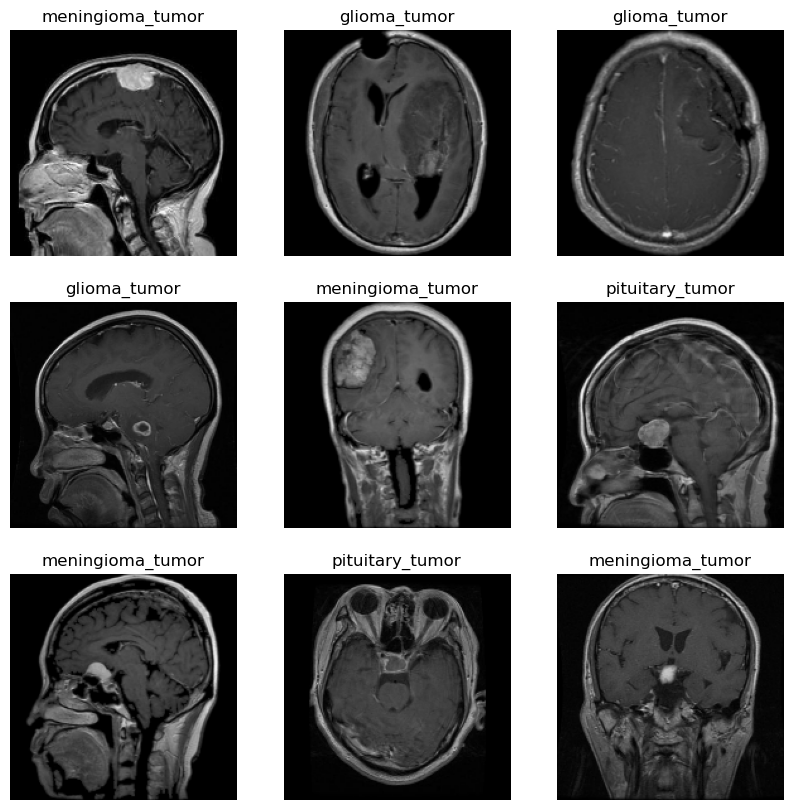

In [140]:
import matplotlib.pyplot as plt

# Let's visualize some of the data to see different classes of tumors.
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [141]:
# Create validation set
val_ds = tf.keras.utils.image_dataset_from_directory(
  '/Users/adnan/Documents/datasets/brain_tumor_classification/Validation/',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1205 files belonging to 4 classes.


In [142]:
# Prepare datasets using prefetch and cache to improve performance on device
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(100).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [143]:
num_classes = len(class_names)
# Use augmentation to make some changes to images and help improve training
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.Resizing(img_height,img_width,)
  ]
)
# Put together all the layers for the model.
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [144]:
# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [145]:
model.summary() # Visualize final structure of model

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_14 (Sequential)      │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_7 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [146]:
# Train the model and get the accuracies
training_history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=25
)

Epoch 1/25
258/258 ━━━━━━━━━━━━━━━━━━━━ 29s 110ms/step - accuracy: 0.4657 - loss: 1.1839 - val_accuracy: 0.4307 - val_loss: 1.3231
Epoch 2/25
258/258 ━━━━━━━━━━━━━━━━━━━━ 27s 106ms/step - accuracy: 0.6525 - loss: 0.8292 - val_accuracy: 0.5693 - val_loss: 1.1546
Epoch 3/25
258/258 ━━━━━━━━━━━━━━━━━━━━ 28s 107ms/step - accuracy: 0.7134 - loss: 0.6985 - val_accuracy: 0.6332 - val_loss: 1.0681
Epoch 4/25
258/258 ━━━━━━━━━━━━━━━━━━━━ 31s 119ms/step - accuracy: 0.7916 - loss: 0.5354 - val_accuracy: 0.6531 - val_loss: 0.9826
Epoch 5/25
258/258 ━━━━━━━━━━━━━━━━━━━━ 28s 109ms/step - accuracy: 0.8192 - loss: 0.4905 - val_accuracy: 0.6357 - val_loss: 1.0867
Epoch 6/25
258/258 ━━━━━━━━━━━━━━━━━━━━ 27s 106ms/step - accuracy: 0.8384 - loss: 0.4005 - val_accuracy: 0.7303 - val_loss: 0.8163
Epoch 7/25
258/258 ━━━━━━━━━━━━━━━━━━━━ 27s 105ms/step - accuracy: 0.8754 - loss: 0.3397 - val_accuracy: 0.7203 - val_loss: 0.8482
Epoch 8/25
258/258 ━━━━━━━━━━━━━━━━━━━━ 27s 104ms/step - accuracy: 0.8861 - loss: 0

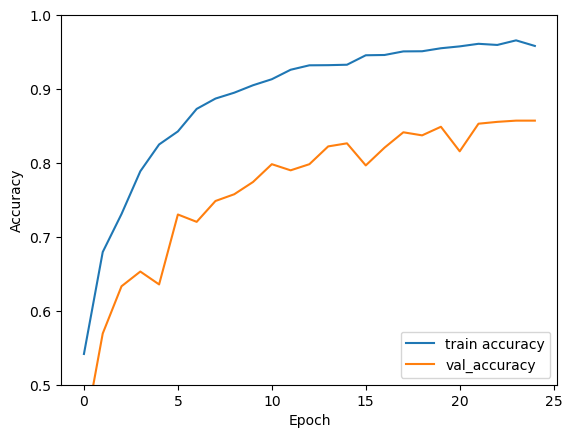

In [147]:
# Plot our training history
plt.plot(training_history.history['accuracy'], label='train accuracy')
plt.plot(training_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')


Final model accuracy on validation set is around 85%. Now, let's try to make a prediction on a never before seen MRI brain scan.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
This MRI scan most likely belongs to meningioma_tumor with a 100.00 percent confidence.


(-0.5, 179.5, 179.5, -0.5)

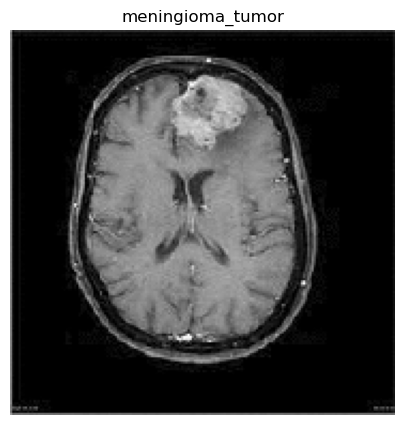

In [158]:
# Let's try to predict on a never before seen MRI brain scan
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np
import tensorflow as tf

# Define the local path to the image and the target size
local_image_path = '/Users/adnan/Desktop/menin.jpeg'

# Load the image from the local path
image = load_img(local_image_path, target_size=(img_height, img_width))

# Convert the image to an array
img_np = img_to_array(image)


# Expand the dimensions to match what's expected
img_array = np.expand_dims(img_np, axis=0)

# Make single prediction
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# Print the result with the most likely class and confidence
print(
    "This MRI scan most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

plt.figure(figsize=(5, 5))
plt.imshow(img_np.astype('uint8'))
plt.title(class_names[np.argmax(score)])
plt.axis("off")